In [1]:
import urllib.request
import json
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import requests
import re

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

In [2]:
street_data_url = 'https://geodata.tampere.fi/geoserver/osoitteet/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=MV_KATUOSOITTEET_GSVIEW&outputFormat=json'

with urllib.request.urlopen(street_data_url) as url:
    street_data = json.load(url)
    
street_coordinates = {
    f['properties']['KATUOSOITE']: tuple(f['geometry']['coordinates'])
    for f in street_data['features']}    

In [3]:
#  downloaded from https://data.tampere.fi/data/fi/dataset/tampereen-suunnittelualueet

shp_path = "shp-files/KH_SUUNNITTELUALUEPolygon.shp"
sf = shp.Reader(shp_path, encoding="latin1")

In [4]:
def shp_to_df(sf):
    '''
    converts shapefily into pandas dataframe.
    '''
    fields = [x[0] for x in sf.fields][1:]
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def calc_color(data):
    '''
    creates a color pallette for the map
    '''
    color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494'] 
    colors = 'YlGnBu'

    new_data, bins = pd.qcut(data, 6, retbins=True, labels=list(range(6)))
    color_ton = [color_sq[val] for val in new_data]
    colors = sns.color_palette(colors, n_colors=6)
    sns.palplot(colors, 0.6)
    for i in range(6):
        print ("\n"+str(i+1)+': '+str(int(bins[i]))+ " €" +
               " => "+str(int(bins[i+1])-1) + " €")
    print("\n\n    1   2    3   4    5   6")
    return color_ton, bins

def plot_areas_data(sf, title, areas, excluded_areas=None, data=None, print_id=False):
    color_ton, bins = calc_color(data)
    df = shp_to_df(sf)
    area_id = [df[df.NIMI == i.upper()].index[0] for i in areas]
    plot_map_fill_multiples_ids_tone(
        sf,
        title,
        area_id,
        print_id,
        color_ton,
        bins,
        excluded_areas
        )
    return
    
def plot_map_fill_multiples_ids_tone(sf, title, area, print_id, color_ton, bins, excluded_areas=None, x_lim=None, y_lim=None, figsize=(11,9)):
    if excluded_areas is None:
        excluded_areas = []
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    ax.grid(False)
    ax.axis('off')
    fig.suptitle("\n" + title, fontsize=22, y=0.98)
    for shape in sf.shapeRecords():
        if shape.record[0] not in excluded_areas:
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            ax.plot(x, y, 'k')
            
    for _id in area:
        if sf.shapeRecords()[_id].record[0] not in excluded_areas:
            shape_ex = sf.shape(_id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[area.index(_id)])
            if print_id:
                x0 = np.mean(x_lon)
                y0 = np.mean(y_lat)
                plt.text(x0, y0, _id, fontsize=10)
                
    if (x_lim is not None) & (y_lim is not None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    return

In [5]:
df = shp_to_df(sf)
area_coordinates = {row['NIMI']: row['coords'] for _, row in df.iterrows()}

In [6]:
def scrape_etuovi(url, max_pages=999):
    '''
    scrapes listings from Etuovi with given url. 
    returns dict with id, address, price and size.
    '''
    db = {}
    urls = []
    for i in range(1, max_pages + 1):
        search_url = f'{url}&sivu={str(i)}'
        page = requests.get(search_url)
        soup = BeautifulSoup(page.text, 'html.parser')

        for single_soup in soup.find_all('div', {'class': 'Lloosjx'}):
            try:
                address = single_soup.find('h4', {'class': re.compile('MuiTypography-root MuiTypography-body1')}).text
                price = float(single_soup.text.split("€")[0].split('Hinta')[1].replace('\xa0', '').replace(",","."))
                size = single_soup.text.split("m²")[0].split("Koko")[1].strip()
                item_id = single_soup.find('a', href=True)['href'].split("kohde/")[1].split("?")[0]
                db[item_id] = {'address': address, 'price': price, 'size': size}
            except (IndexError, ValueError):
                continue

        sub_urls = ['https://www.etuovi.com' + x['href'] for x in soup.find_all('a', href=True) if 'kohde' in x['href']]
        
        if set(sub_urls).intersection(set(urls)) == set(sub_urls):
            break
        urls += sub_urls
    print(f"Scraped {len(db)} listings.")
    return db

def combine_db_with_coordinates(db):
    '''
    combines db generated by etuovi scraper with coordinate data.
    '''
    db_with_coordinates = {}
    for _id, data in db.items():
        coords = None
        street_address = data['address'].split(",")[0].strip()
        if street_coordinates.get(street_address):
            coords = street_coordinates.get(street_address)
        else:
            for a in street_coordinates.keys():
                if a.startswith(street_address.strip()):
                    coords = street_coordinates.get(a)
                    break
        if coords is not None:
            db_with_coordinates[street_address] = (data['price'], data['size'], coords)

    print(f"Number of listings shrunk to {len(db_with_coordinates)}.")
    return db_with_coordinates

def get_area_prices(db_with_coordinates):
    '''
    combines price data with area coordinates
    '''
    area_prices = {}
    n_listings = 0
    for street_address, data in db_with_coordinates.items():
        point = shapely.geometry.Point(*data[-1])
        for area, coordinates in area_coordinates.items():
            if not area_prices.get(area):
                area_prices[area] = []
            line = shapely.geometry.LineString(coordinates)
            polygon = shapely.geometry.Polygon(line)
            if polygon.contains(point):
                try:
                    price_m2 = data[0] / float(data[1].split("/")[0])
                    area_prices[area].append(price_m2)     
                    n_listings += 1
                except ValueError:
                    continue
    print(f'Final number of eligable listings: {n_listings}')
    return area_prices

In [7]:
url = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M2020433873'
db = scrape_etuovi(url)
db_with_coordinates = combine_db_with_coordinates(db)
area_prices = get_area_prices(db_with_coordinates)
area_prices_avg = {area: np.mean(prices) for area, prices in area_prices.items() if prices}
empty_areas = [area for area, prices in area_prices.items() if not prices]
print("Could not find any listings in following areas:")
for area in empty_areas:
    print(f" {area}")

Scraped 3573 listings.
Number of listings shrunk to 1084.
Final number of eligable listings: 722
Could not find any listings in following areas:
 NIIHAMA
 RUSKO
 MYLLYPURO
 OJALA



1: 1828 € => 2090 €

2: 2091 € => 2480 €

3: 2481 € => 2679 €

4: 2680 € => 3287 €

5: 3288 € => 4197 €

6: 4198 € => 5492 €


    1   2    3   4    5   6


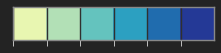

<Figure size 792x648 with 0 Axes>

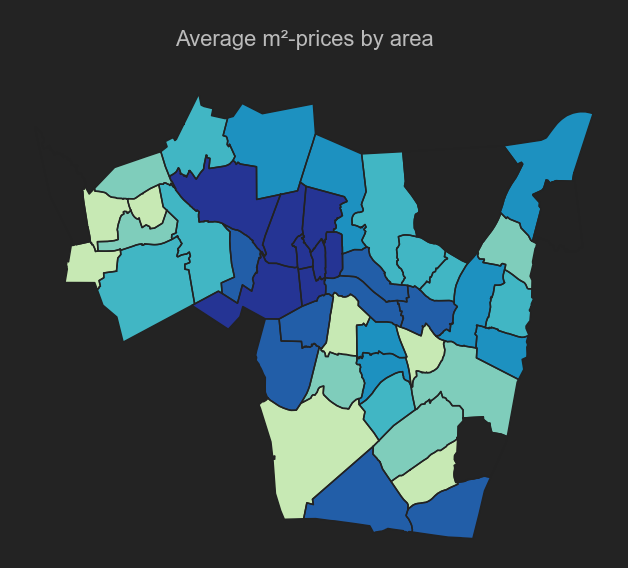

In [12]:
areas = sorted(area_prices_avg.keys())
prices_avg = [area_prices_avg[a] for a in areas]

excluded_areas = ['TEISKO', 'KÄMMENNIEMI', 'NURMI-SORILA']
print_id = False 
plot_areas_data(sf, u"Average m\u00b2-prices by area", areas, excluded_areas, prices_avg, print_id)